# Custom Observer

This example defines a plane-observer in python.

In [1]:
import crpropa

class ObserverPlane(crpropa.ObserverFeature):
    """
    Detects all particles after crossing the plane. Defined by position (any
    point in the plane) and vectors v1 and v2.
    """
    def __init__(self, position, v1, v2):
        crpropa.ObserverFeature.__init__(self)

        # calculate three points of a plane
        self.__v1 = v1
        self.__v2 = v2
        self.__x0 = position

    def distanceToPlane(self, X):
        """
        Always positive for one side of plane and negative for the other side.
        """
        dX = np.asarray([X.x - self.__x0[0], X.y - self.__x0[1], X.z - self.__x0[2]])
        V = np.linalg.det([self.__v1, self.__v2, dX])
        return V

    def checkDetection(self, candidate):

        currentDistance = self.distanceToPlane(candidate.current.getPosition())
        previousDistance = self.distanceToPlane(candidate.previous.getPosition())
        candidate.limitNextStep(abs(currentDistance))

        if np.sign(currentDistance) == np.sign(previousDistance):
            return crpropa.NOTHING
        else:
            return crpropa.DETECTED

As test, we propagate some particles in a random field with a sheet observer:

In [2]:
from crpropa import Mpc, nG, EeV
import numpy as np

turbSpectrum = crpropa.SimpleTurbulenceSpectrum(Brms=1*nG, lMin = 2*Mpc, lMax=5*Mpc, sIndex=5./3.)
gridprops = crpropa.GridProperties(crpropa.Vector3d(0), 128, 1 * Mpc)
BField = crpropa.SimpleGridTurbulence(turbSpectrum, gridprops)

m = crpropa.ModuleList()
m.add(crpropa.PropagationCK(BField, 1e-4, 0.1 * Mpc, 5 * Mpc))
m.add(crpropa.MaximumTrajectoryLength(25 * Mpc))

# Observer
out = crpropa.TextOutput("sheet.txt")
o = crpropa.Observer()
# The Observer feature has to be created outside of the class attribute
# o.add(ObserverPlane(...)) will not work for custom python modules
plo = ObserverPlane(np.asarray([0., 0, 0]) * Mpc, np.asarray([0., 1., 0.]) * Mpc, np.asarray([0., 0., 1.]) * Mpc)
o.add(plo)
o.setDeactivateOnDetection(False)
o.onDetection(out)
m.add(o)

# source setup
source = crpropa.Source()
source.add(crpropa.SourcePosition(crpropa.Vector3d(0, 0, 0) * Mpc))
source.add(crpropa.SourceIsotropicEmission())
source.add(crpropa.SourceParticleType(crpropa.nucleusId(1, 1)))
source.add(crpropa.SourceEnergy(1 * EeV))

m.run(source, 1000)
out.close()

and plot the final position of the particles in 3D

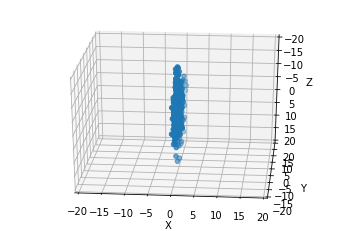

In [3]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import pylab as plt

ax = plt.subplot(111, projection='3d')

data = plt.loadtxt('sheet.txt')

ax.scatter(data[:,5], data[:,6], data[:,7] )
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(20,-20)
ax.set_ylim(20,-20)
ax.set_zlim(20,-20)
ax.view_init(25, 95)

or as a histogram. Note the width of the X distribution, which is due to the particles being detected after crossing.

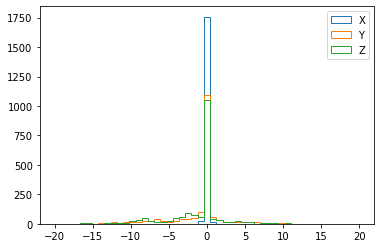

In [5]:
bins = np.linspace(-20,20, 50)
plt.hist(data[:,5], bins=bins, label='X', histtype='step')
plt.hist(data[:,6], bins=bins, label='Y', histtype='step')
plt.hist(data[:,7], bins=bins, label='Z', histtype='step')
plt.legend()
plt.show()